In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

## Uploading and preprocessing data

In [2]:
df = pd.read_csv('data/air_data_clean.csv')
df['date_time']=pd.to_datetime(df['date_time'], origin='1899-12-30', unit='D')

df['date_time'] = pd.to_datetime(df['date_time'], format='%d/%m/%Y')

# Replace '<Samp' values with 0
df = df.replace('<Samp', 0)

# Convert all non-numeric values (except dates) to NaN
numeric_columns = df.columns[1:]  # All columns except the date column
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Convert negative values to 0
df[numeric_columns] = df[numeric_columns].clip(lower=0)
    
# Calculate row means excluding NaN values
# axis=1 means calculate across columns
# skipna=True means ignore NaN values   
df['CO_Israel'] = df[numeric_columns].mean(axis=1, skipna=True)
df['half_month'] = df['date_time'].dt.day.apply(lambda x: 1 if x <= 15 else 2)

In [3]:
# transform daily data to half-monthly data

df_downsampled = df.groupby([
        df['date_time'].dt.year.rename('year'),
        df['date_time'].dt.month.rename('month'),
        'half_month'
    ])[df.columns[1:-1]].mean().reset_index()

# Create proper datetime for the downsampled data (using the 1st and 16th of each month)
df_downsampled['date_time'] = pd.to_datetime(
    df_downsampled.apply(
        lambda x: f"{int(x['year'])}-{int(x['month'])}-{1 if x['half_month']==1 else 16}",
        axis=1
    ))

In [4]:
air = df_downsampled.drop(["year", "month", "half_month"], axis=1)

In [5]:
air = air[["date_time", "CO_Israel", *air.columns.difference(["date_time", "CO_Israel"])]]

In [6]:
air_longer = air.melt(id_vars=['date_time'], var_name='station', value_name='CO_level')

In [7]:
# extract trend for each station
def extract_decomposition(group):
    group = group.dropna(subset=['CO_level'])
    decomposition = seasonal_decompose(group['CO_level'], period=24, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    return group

In [12]:
air_decomposition = (
    air_longer.set_index("station")
    .groupby("station", group_keys=False, sort=False)
    .apply(extract_decomposition)
    .reset_index()
)

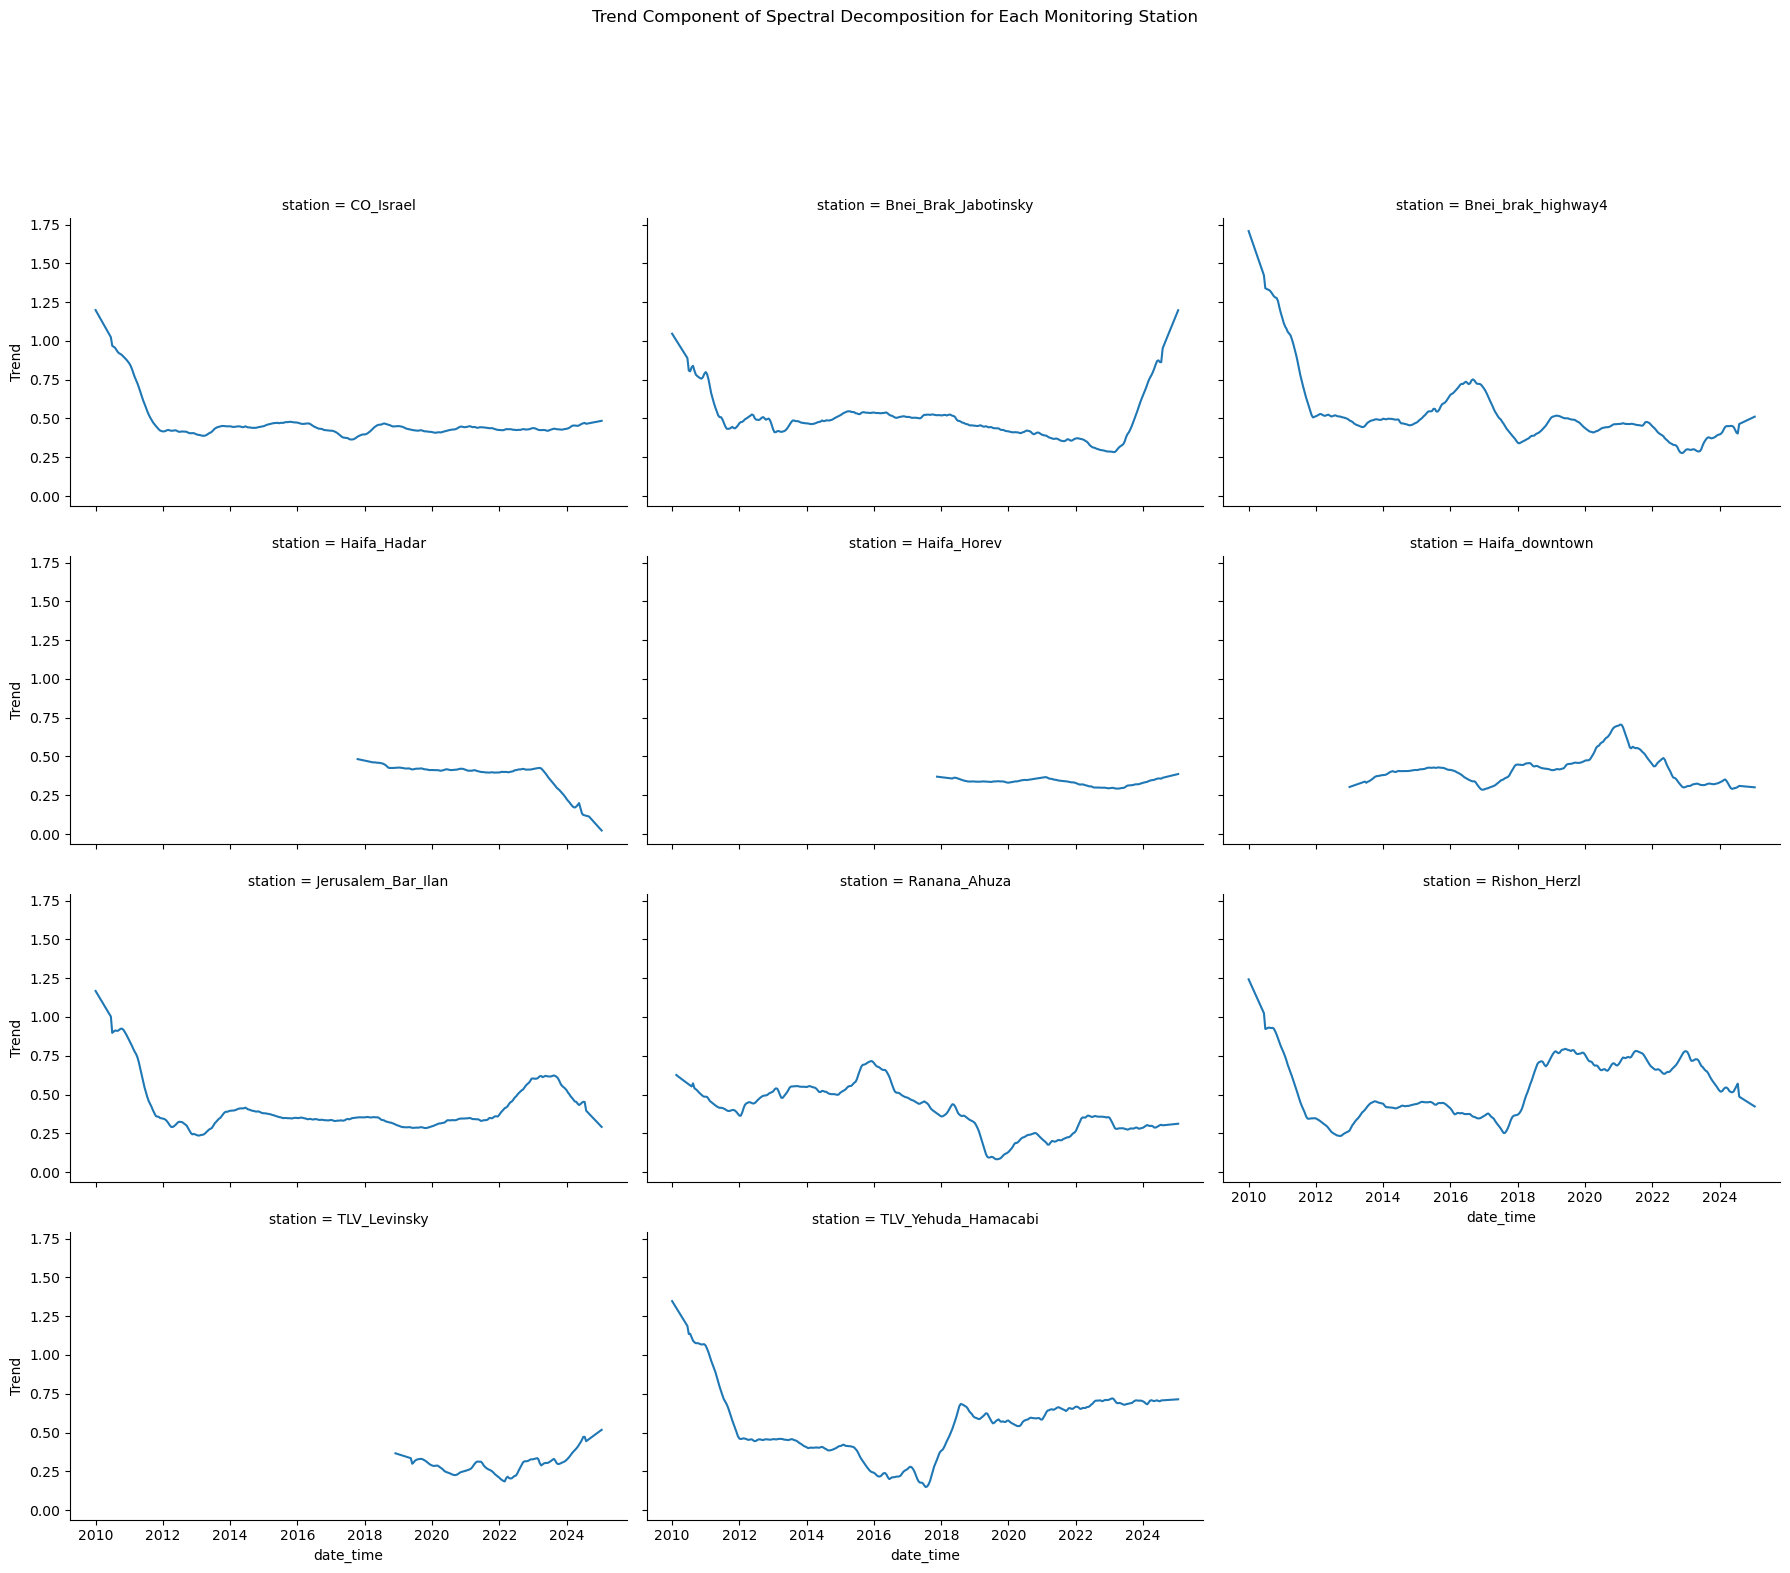

In [15]:
# Plot using FacetGrid
g = sns.FacetGrid(air_decomposition, col="station", col_wrap=3,  sharey=True, sharex=True, height=4, aspect=1.5)
g.map(sns.lineplot, "date_time", "Trend")

# Add title and adjust layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Trend Component of Spectral Decomposition for Each Monitoring Station")

# Show plot
plt.show()

While all monitoring stations active at 2010 shows a significant decrease in pollution from 2010 to 2012, the monotonic trend observed afterwards in the state-average data is not consistently reflected at the individual station level. For example, the stations at TLV - Yehuda Hamacabi and Rishon - Herzl exhibits a substantial increase in pollution at 2018, with a similar but milder rise observed Haifa Downtown that same year. Towards 2024, some stations, such as those in Bnei Brak, shows increasing pollution levels  (for example, the stations on Bnei-Brak) while other cities shows a decrease (e.g, Rishon, Jerusalem, Haifa Hadar).

In [35]:
# # Plot using FacetGrid
# g = sns.FacetGrid(air_decomposition, col="station", col_wrap=3,  sharey=True, sharex=True, height=4, aspect=1.5)
# g.map(sns.lineplot, "date_time", "Seasonal")

# # Add title and adjust layout
# plt.subplots_adjust(top=0.85)
# g.fig.suptitle("Seasonal Component of Spectral Decomposition for Each Monitoring Station")

# # Show plot
# plt.show()

In [42]:
def plot_spectral(df, spectral_component):
    plt.figure(figsize = (12, 6))
    sns.lineplot(data = df, x="date_time", y=spectral_component, hue = "station")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Year")
    plt.ylabel(spectral_component)
    plt.title("{} component of spectral decomposition for all monitoring stations".format(spectral_component))
    plt.show()

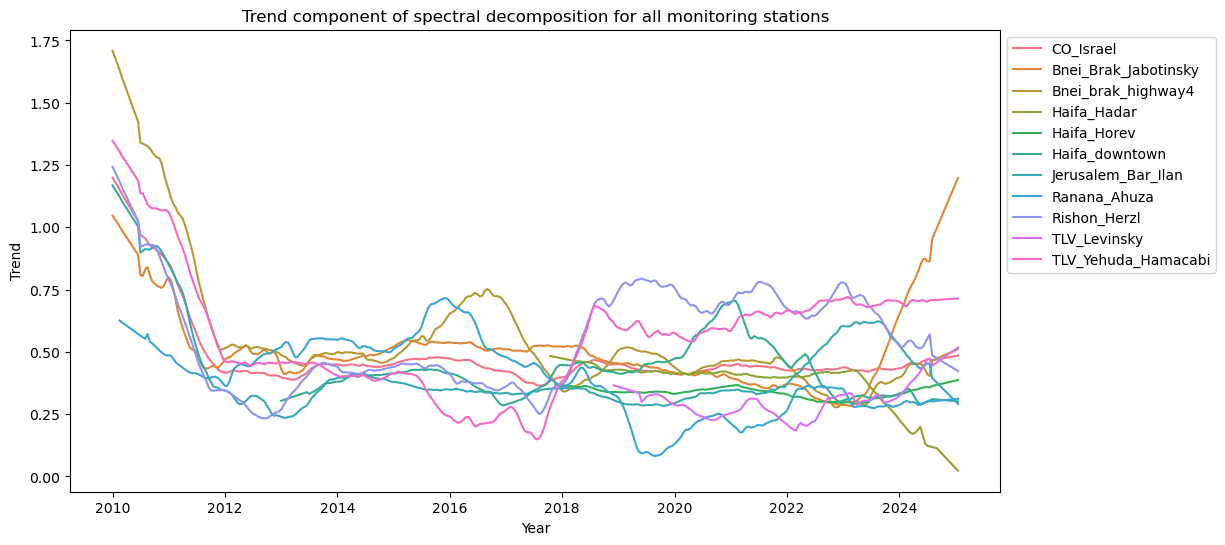

In [43]:
plot_spectral(air_decomposition, "Trend")

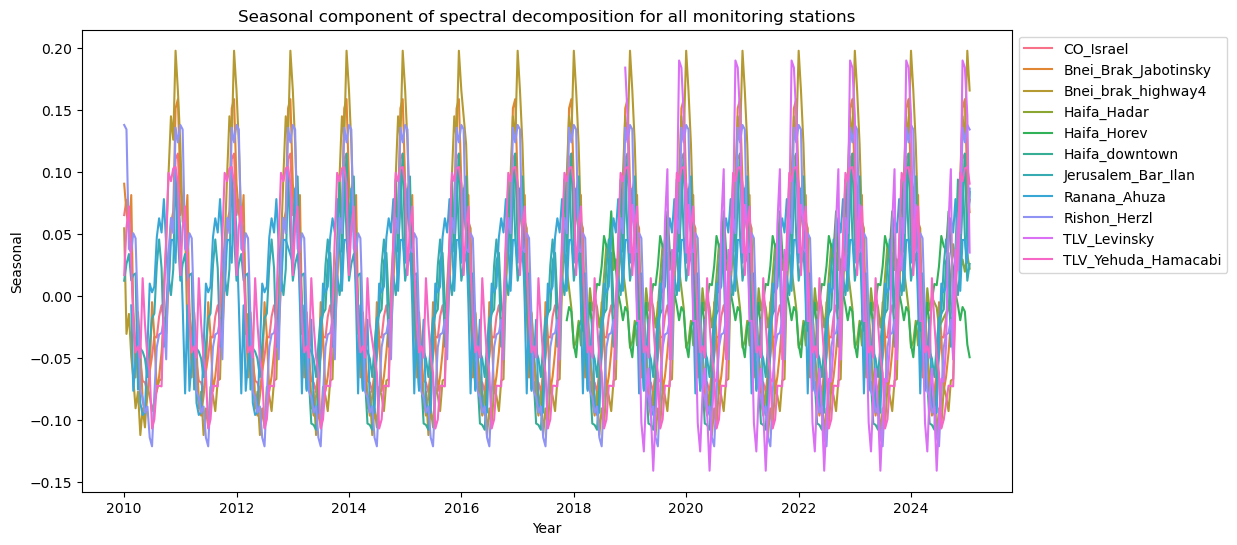

In [44]:
plot_spectral(air_decomposition, "Seasonal")

In [63]:
subset_center = air_decomposition[air_decomposition['station'].str.contains('Bnei_Brak|Israel|TLV_Y|Rishon|Rana', case=False, na = False)]

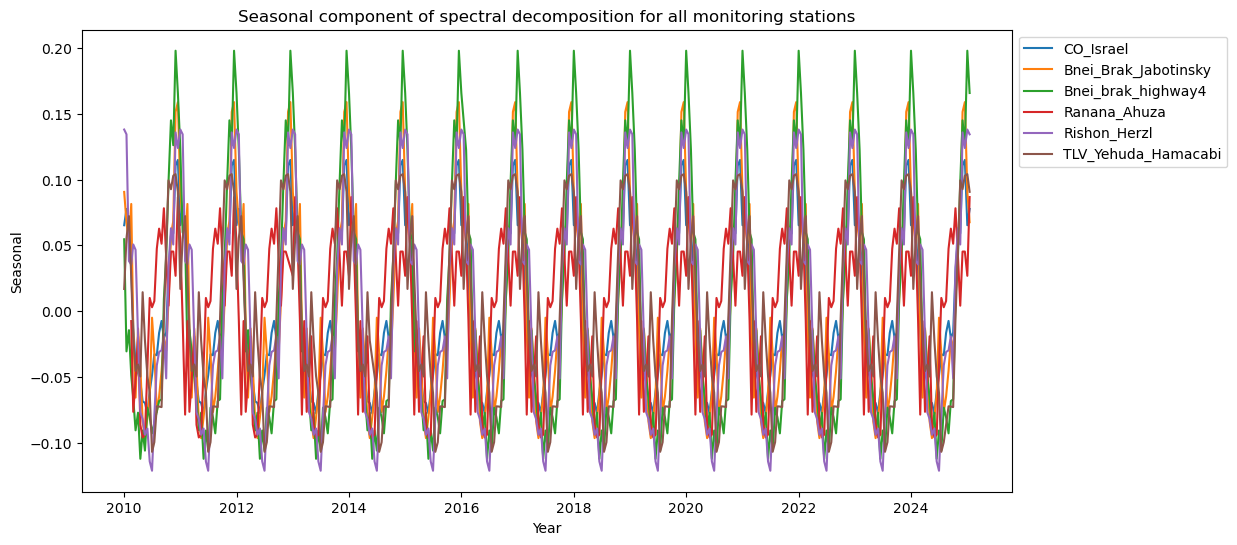

In [64]:
plot_spectral(subset_center, "Seasonal")

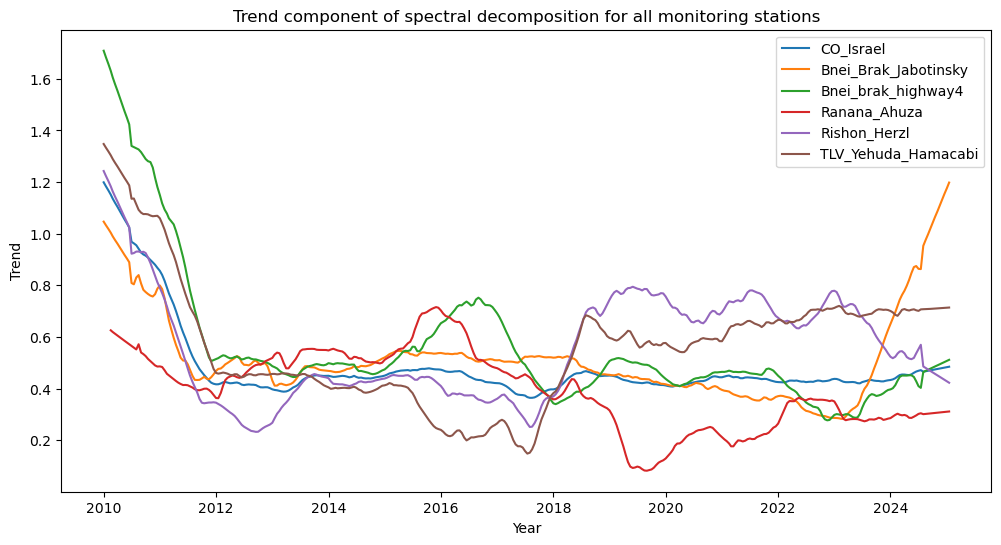

In [65]:
plot_spectral(subset_center, "Trend")